## Road Network and Distance Matrix

In [1]:
# import all the necessary libraries for time-seires analysis and network analysis
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import os
import sys
import math
import random
import itertools
import operator
import collections
from collections import Counter
from collections import defaultdict
from collections import OrderedDict
import osmnx as ox
import time
import geopandas as gpd
from shapely.wkt import loads as load_wkt
from shapely.geometry import LineString, MultiLineString
from shapely.geometry import Point
import random

c:\Users\SBH\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import itertools
import osmnx as ox
# all the unique values for the edges attributes 'highway':
"""
{'_', 'a', 'c', 'd', 'e', 'f', 'g', 'i', 'k', 'l', 'living_street', 'm', 'motorway', 'motorway_link', 'n', 'o',
 'p', 'primary', 'primary_link', 'r', 'residential', 's', 'secondary', 'secondary_link', 't', 'tertiary', 'tertiary_link', 'trunk',
 'trunk_link', 'u', 'unclassified', 'v', 'w', 'y'}
"""

"\n{'_', 'a', 'c', 'd', 'e', 'f', 'g', 'i', 'k', 'l', 'living_street', 'm', 'motorway', 'motorway_link', 'n', 'o',\n 'p', 'primary', 'primary_link', 'r', 'residential', 's', 'secondary', 'secondary_link', 't', 'tertiary', 'tertiary_link', 'trunk',\n 'trunk_link', 'u', 'unclassified', 'v', 'w', 'y'}\n"

In [3]:
city_namelist_OSM = ['Suzhou City, Jiangsu, China','Yangzhou City, Jiangsu, China','Anqing, Anhui, China','Changzhou, Jiangsu, China', 'Chizhou, Anhui, China',
                 '滁州市','Hangzhou City, Zhejiang, China', 'Hefei, Anhui, China','Huzhou, Zhejiang, China','Jiaxing, Zhejiang, China',
                 'Jinhua, Zhejiang, China',"Ma'anshan, Anhui, China", 'Nanjing, Jiangsu, China','Nantong, Jiangsu, China','Ningbo, Zhejiang, China',
                 'Shaoxing, Zhejiang, China','Taizhou, Zhejiang, China','Taizhou, Jiangsu, China','Tongling, Anhui, China','Wuxi City, Jiangsu, China',
                 'Wuhu, Anhui, China','Xuancheng, Anhui, China','Yancheng City, Jiangsu, China','Zhenjiang, Jiangsu, China','Zhoushan, Zhejiang, China','Shanghai, China']
city_namelist_OSM_en = ['Suzhou City, Jiangsu, China','Yangzhou City, Jiangsu, China','Anqing, Anhui, China','Changzhou, Jiangsu, China', 'Chizhou, Anhui, China',
                 'Chuzhou, Anhui, China','Hangzhou City, Zhejiang, China', 'Hefei, Anhui, China','Huzhou, Zhejiang, China','Jiaxing, Zhejiang, China',
                 'Jinhua, Zhejiang, China',"Ma'anshan, Anhui, China", 'Nanjing, Jiangsu, China','Nantong, Jiangsu, China','Ningbo, Zhejiang, China',
                 'Shaoxing, Zhejiang, China','Taizhou, Zhejiang, China','Taizhou, Jiangsu, China','Tongling, Anhui, China','Wuxi City, Jiangsu, China',
                 'Wuhu, Anhui, China','Xuancheng, Anhui, China','Yancheng City, Jiangsu, China','Zhenjiang, Jiangsu, China','Zhoushan, Zhejiang, China','Shanghai, China']


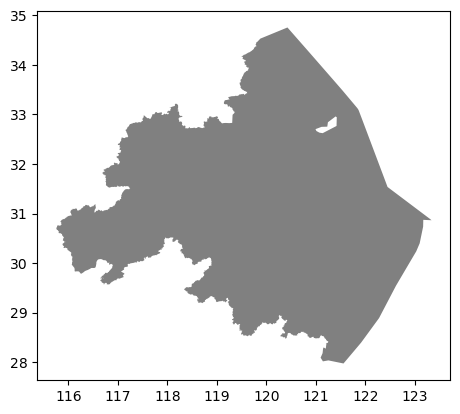

In [4]:

# download the administrative boundary data of the city
gdf = ox.geocoder.geocode_to_gdf(city_namelist_OSM)


# union all the polygons into one polygon
union_polygon = gdf.unary_union

# convert the union polygon into a GeoDataFrame
union_gdf = gpd.GeoDataFrame(geometry=[union_polygon])

# set the crs of the union_gdf
union_gdf.set_geometry('geometry', inplace=True)

# plot the union_gdf
fig, ax = plt.subplots()
union_gdf.plot(ax=ax, facecolor='gray')
plt.show()


In [5]:
# download the road network from osmnx based on the union_polygon
G = ox.graph_from_polygon(union_polygon, network_type='drive', custom_filter='["highway"~"motorway|motorway_link|primary|primary_link|secondary|secondary_link"]')

c:\Users\SBH\anaconda3\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 132 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


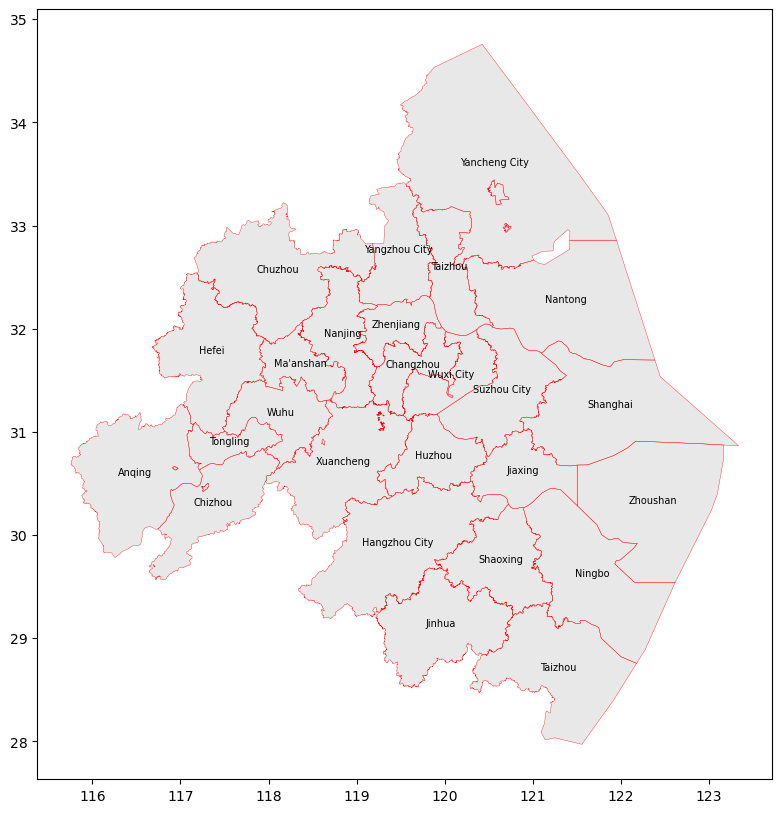

In [6]:
# import the city boundary shp file
city_boundary = gpd.read_file('Data/python/Area_boundary.shp')
# plot the city boundary
# plot the gdf data, and add the basemap
fig, ax = plt.subplots(figsize=(10,10))
city_boundary.boundary.plot(ax=ax, edgecolor='red', linewidth=0.25, alpha=1)
# fill the boundary with a color
city_boundary.plot(ax=ax, facecolor='lightgray', alpha=0.5)
# label the city name, set the font size to 5
city_boundary.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=7), axis=1)

# add the basemap
#ctx.add_basemap(ax, crs=city_boundary.crs, source=ctx.providers.OpenStreetMap.DE)
plt.show()

In [7]:
# print the crs of the city boundary
print(city_boundary.crs)

EPSG:4326


In [ ]:

# check which city boundary each node is within and update the node attributes
for node, data in G.nodes(data=True):
    point = Point(data['x'], data['y'])  # create a point geometry for each node
    found_city = False
    for idx, row in city_boundary.iterrows():
        if point.within(row['geometry']):
            data['city_name'] = row['display_na']
            data['city_osmid'] = row['osm_id']
            found_city = True
            break
    if not found_city:
        data['city_name'] = 'outside'
        data['city_osmid'] = 'none'


# change teh G graph to an undirected graph
G = G.to_undirected()

#check if city_boundary and G_read are in the same coordinate system
print(city_boundary.crs)
print(G.graph['crs'])
#check the graph if it is directed and connected
print(nx.is_directed(G))
print(nx.is_connected(G))

#check how many nodes with city_name attribute = 'outside'
outside_nodes = [node for node, data in G.nodes(data=True) if data['city_name'] == 'outside']
print(len(outside_nodes))
# delete the nodes with city_name attribute = 'outside' from the graph, along with the corresponding edges
G.remove_nodes_from(outside_nodes)
print(len(outside_nodes))

   

In [28]:
# save the graph to a graphml file
output_file = 'Data/python/combined_road_network.graphml'
ox.save_graphml(G, output_file)

In [27]:
# for all nodes in the graph, change value of the attribute 'city_name' from 'Nanjing City, Jiangsu, China' to 'Nanjing, Jiangsu, China'
"""
for node, data in G.nodes(data=True):
    if data['city_name'] == 'Nanjing City, Jiangsu, China':
        data['city_name'] = 'Nanjing, Jiangsu, China'
"""

In [29]:
# read the graphml file
output_file = 'Data/python/combined_road_network.graphml'
G = ox.load_graphml(output_file)

In [30]:
#check how many nodes with each unique city_name attribute
city_names = [data['city_name'] for node, data in G.nodes(data=True)]
city_name_counts = Counter(city_names)
# save the city_name_counts to a pandas dataframe
city_name_counts_df = pd.DataFrame.from_dict(city_name_counts, orient='index').reset_index()
city_name_counts_df.columns = ['city_name', 'count']
city_name_counts_df = city_name_counts_df.sort_values(by='count', ascending=False)

In [32]:
# generate a list of city pairs, if any two cities in city_boundary have shared boundaries (i.e., are adjacent), then add the city pair to this list of lists
city_pairs = []
for idx1, row1 in city_boundary.iterrows():
    for idx2, row2 in city_boundary.iterrows():
        if row1['geometry'].intersects(row2['geometry']) and row1['display_na'] != row2['display_na']:
            city_pairs.append([row1['display_na'], row2['display_na']])
len(city_pairs)

126

In [42]:
#generate a list of city pairs, which are the every combination of each two cities in the city list, and then add the city pair to this list of lists
city_pairs_all = []
# su

for pair in itertools.combinations(city_namelist_OSM_en, 2):
    city_pairs_all.append(pair)
len(city_pairs_all)

325

In [43]:
# remove all the duplicates in the city_pairs list, including the reversed pairs
city_pairs = list(set([tuple(sorted(pair)) for pair in city_pairs]))
city_pairs = [list(pair) for pair in city_pairs]  # convert the list of tuples back to a list of lists
len(city_pairs)

63

In [44]:
# convert this list to a pandas dataframe, where each row is a city pair, columns are 'city1' and 'city2'
city_pairs_df = pd.DataFrame(city_pairs, columns=['city1', 'city2'])
# create a new column 'city_distance' filled with 0
city_pairs_df['city_distance'] = 0.000
city_pairs_df.sample(5)

,city1,city2,city_distance
27,"Nanjing, Jiangsu, China","Xuancheng, Anhui, China",0.0
7,"Changzhou, Jiangsu, China","Xuancheng, Anhui, China",0.0
42,"Shanghai, China","Yancheng City, Jiangsu, China",0.0
5,"Nanjing, Jiangsu, China","Yangzhou City, Jiangsu, China",0.0
48,"Changzhou, Jiangsu, China","Taizhou, Jiangsu, China",0.0


In [45]:
# convert this list to a pandas dataframe, where each row is a city pair, columns are 'city1' and 'city2'
city_pairs_all_df = pd.DataFrame(city_pairs_all, columns=['city1', 'city2'])
# create a new column 'city_distance' filled with 0
city_pairs_all_df['city_distance'] = 0.000
city_pairs_all_df.sample(5)

,city1,city2,city_distance
18,"Suzhou City, Jiangsu, China","Wuxi City, Jiangsu, China",0.0
259,"Ningbo, Zhejiang, China","Shaoxing, Zhejiang, China",0.0
7,"Suzhou City, Jiangsu, China","Huzhou, Zhejiang, China",0.0
147,"Hangzhou City, Zhejiang, China","Wuxi City, Jiangsu, China",0.0
244,"Nanjing, Jiangsu, China","Zhenjiang, Jiangsu, China",0.0


In [ ]:
# for each city pair, first find all nodes in the road network whose city_name attribute is equal to either city1 and city2
# then calculate the shortest path from each node in city1 to each node in city2, and finally sum up the lengths of all the shortest paths, 
# and store the sum in the 'city_distance' column of the city_pairs_df dataframe
sample_ratio = 0.05
"""   
# define the sample ratio


for idx, row in city_pairs_df.iterrows():
    city1 = row['city1']
    city2 = row['city2']
    city1_nodes = [node for node, data in G.nodes(data=True) if data['city_name'] == city1]
    city2_nodes = [node for node, data in G.nodes(data=True) if data['city_name'] == city2]

    # from city1_nodes and city2_nodes, randomly select 5% of the nodes
    sample_size_city1 = max(1, int(len(city1_nodes) * sample_ratio))
    sample_size_city2 = max(1, int(len(city2_nodes) * sample_ratio))

    sample_city1_nodes = random.sample(city1_nodes, sample_size_city1)
    sample_city2_nodes = random.sample(city2_nodes, sample_size_city2)

    # calculate the shortest path lengths from all nodes in sample_city1_nodes to all nodes in sample_city2_nodes
    total_distance = 0
    for node1 in sample_city1_nodes:
        try:
            lengths = nx.single_source_dijkstra_path_length(G, node1, weight='length')
            for node2 in sample_city2_nodes:
                if node2 in lengths:
                    total_distance += lengths[node2]
        except nx.NetworkXNoPath:
            pass
    city_pairs_df.at[idx, 'city_distance'] = total_distance

"""

In [47]:
# for each city pair in the dataframe city_pairs_all_df, first find all nodes in the road network whose city_name attribute is equal to either city1 and city2
# then calculate the shortest path from each node in city1 to each node in city2, and finally sum up the lengths of all the shortest paths, 
# and store the sum in the 'city_distance' column of the city_pairs_df dataframe
sample_ratio = 0.03

for idx, row in city_pairs_all_df.iterrows():
    city1 = row['city1']
    city2 = row['city2']
    city1_nodes = [node for node, data in G.nodes(data=True) if data['city_name'] == city1]
    city2_nodes = [node for node, data in G.nodes(data=True) if data['city_name'] == city2]

    # from city1_nodes and city2_nodes, randomly select 5% of the nodes
    sample_size_city1 = max(1, int(len(city1_nodes) * sample_ratio))
    sample_size_city2 = max(1, int(len(city2_nodes) * sample_ratio))

    sample_city1_nodes = random.sample(city1_nodes, sample_size_city1)
    sample_city2_nodes = random.sample(city2_nodes, sample_size_city2)

    # calculate the shortest path lengths from all nodes in sample_city1_nodes to all nodes in sample_city2_nodes
    total_distance = 0
    for node1 in sample_city1_nodes:
        try:
            lengths = nx.single_source_dijkstra_path_length(G, node1, weight='length')
            for node2 in sample_city2_nodes:
                if node2 in lengths:
                    total_distance += lengths[node2]
        except nx.NetworkXNoPath:
            pass
    city_pairs_all_df.at[idx, 'city_distance'] = total_distance


In [50]:
city_pairs_df['city1_num_nodes'] = 0
city_pairs_df['city2_num_nodes'] = 0

In [51]:
city_pairs_all_df['city1_num_nodes'] = 0
city_pairs_all_df['city2_num_nodes'] = 0

In [ ]:
# get the number of nodes in city1  and city2 based on the city_name_counts_df dataframe
for idx, row in city_pairs_df.iterrows():
    city1 = row['city1']
    city2 = row['city2']
    city_pairs_df.at[idx, 'city1_num_nodes'] = city_name_counts_df[city_name_counts_df['city_name'] == city1]['count'].values[0]
    city_pairs_df.at[idx, 'city2_num_nodes'] = city_name_counts_df[city_name_counts_df['city_name'] == city2]['count'].values[0]

city_pairs_df.sample(5)

In [52]:
# get the number of nodes in city1  and city2 based on the city_name_counts_df dataframe
for idx, row in city_pairs_all_df.iterrows():
    city1 = row['city1']
    city2 = row['city2']
    city_pairs_all_df.at[idx, 'city1_num_nodes'] = city_name_counts_df[city_name_counts_df['city_name'] == city1]['count'].values[0]
    city_pairs_all_df.at[idx, 'city2_num_nodes'] = city_name_counts_df[city_name_counts_df['city_name'] == city2]['count'].values[0]

city_pairs_all_df.sample(5)

,city1,city2,city_distance,city1_num_nodes,city2_num_nodes
208,"Jinhua, Zhejiang, China","Ningbo, Zhejiang, China",6.091781e+09,4240,7395
197,"Jiaxing, Zhejiang, China","Tongling, Anhui, China",6.535719e+08,3543,628
285,"Taizhou, Zhejiang, China","Yancheng City, Jiangsu, China",7.837371e+09,3654,3853
222,"Ma'anshan, Anhui, China","Ningbo, Zhejiang, China",2.640089e+09,902,7395
317,"Xuancheng, Anhui, China","Zhoushan, Zhejiang, China",2.575195e+08,1262,593


In [ ]:
city_pairs_df['num_nodepair'] = (city_pairs_df['city1_num_nodes'] * sample_ratio) * (city_pairs_df['city2_num_nodes'] * sample_ratio)
city_pairs_df['city_distance_index'] = city_pairs_df['city_distance'] / city_pairs_df['num_nodepair']
city_pairs_df.sample(4)

In [53]:
city_pairs_all_df['num_nodepair'] = (city_pairs_all_df['city1_num_nodes'] * sample_ratio) * (city_pairs_all_df['city2_num_nodes'] * sample_ratio)
city_pairs_all_df['city_distance_index'] = city_pairs_all_df['city_distance'] / city_pairs_all_df['num_nodepair']
city_pairs_all_df.sample(4)

,city1,city2,city_distance,city1_num_nodes,city2_num_nodes,num_nodepair,city_distance_index
176,"Huzhou, Zhejiang, China","Nantong, Jiangsu, China",2.391455e+09,2131,5358,10276.1082,232719.893227
321,"Yancheng City, Jiangsu, China","Shanghai, China",1.159222e+10,3853,10079,34950.9483,331671.073372
286,"Taizhou, Zhejiang, China","Zhenjiang, Jiangsu, China",3.297399e+09,3654,2109,6935.6574,475427.055196
162,"Hefei, Anhui, China","Taizhou, Zhejiang, China",1.350846e+10,6424,3654,21125.9664,639424.444450


In [ ]:
# delete two rows, the highest two rows for the city_distance_index column
# because this two rows are from Shanghai to Xuancheng and from Shanghai to Nantong, in which enclave areas exist
city_pairs_df = city_pairs_df.sort_values(by='city_distance_index', ascending=False)
city_pairs_df = city_pairs_df.iloc[2:]
city_pairs_df.head()

In [72]:
city_pairs_all_df.sample(4)

,city1,city2,city_distance,city1_num_nodes,city2_num_nodes,num_nodepair,city_distance_index
200,"Jiaxing, Zhejiang, China","Xuancheng, Anhui, China",9.552234e+08,3543,1262,4024.1394,237373.346369
110,"Chizhou, Anhui, China","Xuancheng, Anhui, China",1.416770e+08,576,1262,654.2208,216558.440235
183,"Huzhou, Zhejiang, China","Wuhu, Anhui, China",6.934171e+08,2131,1722,3302.6238,209959.442187
149,"Hangzhou City, Zhejiang, China","Xuancheng, Anhui, China",2.096000e+09,8293,1262,9419.1894,222524.475743


In [ ]:
# in the city_pairs_df dataframe, in the city1 and city2 columns, 
# find all 'Taizhou, Jiangsu, 225300, China', 'Changzhou, Jiangsu, 213000, China', 'Nanjing City, Jiangsu, China' or 'Wuxi City, Jiangsu, 214000, China'
# and change them into 'Taizhou, Jiangsu, China', 'Changzhou, Jiangsu, China', 'Nanjing, Jiangsu, China' and 'Wuxi City, Jiangsu, China' respectively
city_pairs_df['city1'] = city_pairs_df['city1'].replace({'Taizhou, Jiangsu, 225300, China': 'Taizhou, Jiangsu, China',
                                                            'Changzhou, Jiangsu, 213000, China': 'Changzhou, Jiangsu, China',
                                                            'Nanjing City, Jiangsu, China': 'Nanjing, Jiangsu, China',
                                                            'Wuxi City, Jiangsu, 214000, China': 'Wuxi City, Jiangsu, China'})
city_pairs_df['city2'] = city_pairs_df['city2'].replace({'Taizhou, Jiangsu, 225300, China': 'Taizhou, Jiangsu, China',
                                                            'Changzhou, Jiangsu, 213000, China': 'Changzhou, Jiangsu, China',
                                                            'Nanjing City, Jiangsu, China': 'Nanjing, Jiangsu, China',
                                                            'Wuxi City, Jiangsu, 214000, China': 'Wuxi City, Jiangsu, China'})

city_pairs_df.sample(8)


In [73]:
# save the city_pairs_df dataframe to a csv file
#city_pairs_df.to_csv('Data/python/city_distance_network.csv', index=False)
#city_pairs_all_df.to_csv('Data/python/city_distance_all_network.csv', index=False)

### City Boundary Shapefile

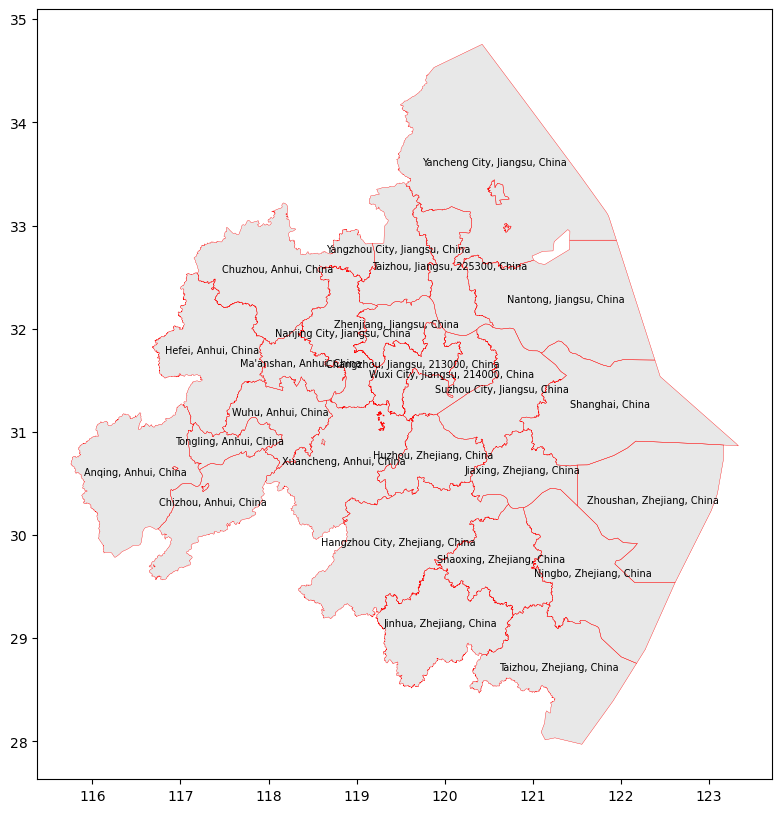

In [ ]:

# 下载城市的行政边界数据
gdf = ox.geocoder.geocode_to_gdf(city_namelist_OSM)

# plot the gdf data, and add the basemap
fig, ax = plt.subplots(figsize=(10,10))
gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=0.25, alpha=1)
# fill the boundary with a color
gdf.plot(ax=ax, facecolor='lightgray', alpha=0.5)
# label the city name, set the font size to 5
gdf.apply(lambda x: ax.annotate(text=x['display_name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=7), axis=1)

# add the basemap
#ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.DE)
plt.show()


In [ ]:
# check the row where name=Wuxi in the city_boundary, change the display_na column's value to Wuxi City, Jiangsu, China
gdf.loc[gdf['display_name'] == 'Wuxi City, Jiangsu, 214000, China', 'display_name'] = 'Wuxi City, Jiangsu, China'
gdf.loc[gdf['display_name'] == 'Taizhou, Jiangsu, 225300, China', 'display_name'] = 'Taizhou, Jiangsu, China'
gdf.loc[gdf['display_name'] == 'Changzhou, Jiangsu, 213000, China', 'display_name'] = 'Changzhou, Jiangsu, China'

# change the name from 'Nanjing City' to 'Nanjing', display_na from 'Nanjing City, Jiangsu, China' to 'Nanjing, Jiangsu, China'
gdf.loc[gdf['display_name'] == 'Nanjing City, Jiangsu, China', 'display_name'] = 'Nanjing, Jiangsu, China'
gdf.loc[gdf['name'] == 'Nanjing City', 'name'] = 'Nanjing'
gdf[gdf['display_name'] == 'Nanjing, Jiangsu, China']

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
12,"MULTIPOLYGON (((118.33459 31.95435, 118.33469 ...",32.615778,31.226748,119.239507,118.334591,198941382,relation,2131524,32.043828,118.778863,boundary,administrative,10,0.632055,city,Nanjing,"Nanjing, Jiangsu, China"


In [ ]:
gdf

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((119.91621 31.17377, 119.91696 31.172...",32.045778,30.760334,121.382253,119.916209,198756612,relation,4430941,31.301693,120.581073,boundary,administrative,10,0.582749,city,Suzhou City,"Suzhou City, Jiangsu, China"
1,"POLYGON ((119.00460 32.41151, 119.00469 32.409...",33.417103,32.224631,119.907342,119.004597,388586469,relation,4430826,32.396855,119.407766,boundary,administrative,10,0.549239,city,Yangzhou City,"Yangzhou City, Jiangsu, China"
2,"POLYGON ((115.75585 30.68945, 115.75674 30.688...",31.271325,29.783958,117.247223,115.755853,393651261,relation,3220387,30.659234,116.630258,boundary,administrative,10,0.266723,region,Anqing,"Anqing, Anhui, China"
3,"MULTIPOLYGON (((119.13485 31.44902, 119.13738 ...",32.062089,31.153021,120.201137,119.134852,378567506,relation,3429666,31.812262,119.969154,boundary,administrative,10,0.432781,city,Changzhou,"Changzhou, Jiangsu, China"
4,"POLYGON ((116.64407 29.69785, 116.64451 29.696...",30.845970,29.565070,118.129539,116.644065,199372702,relation,3164669,30.667109,117.485989,boundary,administrative,10,0.266677,city,Chizhou,"Chizhou, Anhui, China"
5,"POLYGON ((117.15433 32.68585, 117.15448 32.683...",33.219531,31.847928,119.223778,117.154330,225378751,relation,3231588,32.302738,118.313946,boundary,administrative,10,0.266727,city,Chuzhou,"Chuzhou, Anhui, China"
6,"POLYGON ((118.33969 29.47746, 118.34031 29.476...",30.564851,29.188829,120.725485,118.339695,197536454,relation,3221112,30.248963,120.205234,boundary,administrative,10,0.525451,city,Hangzhou City,"Hangzhou City, Zhejiang, China"
7,"POLYGON ((116.68139 31.82147, 116.68139 31.821...",32.542299,30.953063,117.968780,116.681386,382922811,relation,3288965,31.866568,117.281428,boundary,administrative,10,0.562910,city,Hefei,"Hefei, Anhui, China"
8,"POLYGON ((119.23240 30.54873, 119.23372 30.545...",31.182578,30.375619,120.484079,119.232404,378239909,relation,3149738,30.894299,120.085111,boundary,administrative,10,0.387650,city,Huzhou,"Huzhou, Zhejiang, China"
9,"POLYGON ((120.29118 30.56731, 120.29250 30.564...",31.032433,30.257489,121.506256,120.291183,380828323,relation,3308626,30.747442,120.751097,boundary,administrative,10,0.395880,city,Jiaxing,"Jiaxing, Zhejiang, China"


In [ ]:
# 保存为SHP文件
output_filename = "Data/python/Area_boundary.shp"
gdf.to_file(output_filename)

C:\Users\SBH\AppData\Local\Temp\ipykernel_12384\3824937261.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_filename)
